In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/Fake.csv
/kaggle/input/fake-and-real-news-dataset/True.csv


In [6]:
!pip install -q -U watermark
!pip install -qq transformers

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [7]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.7.6
IPython 7.13.0

numpy 1.18.1
pandas 1.0.3
torch 1.5.0
transformers 2.9.0


#### Thank you to: [https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/](https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)

In [8]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
fake = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
true = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')

In [15]:
# Set labels for training data
fake['label'] = 0
true['label'] = 1

In [72]:
combined = pd.concat([fake, true], axis=0)

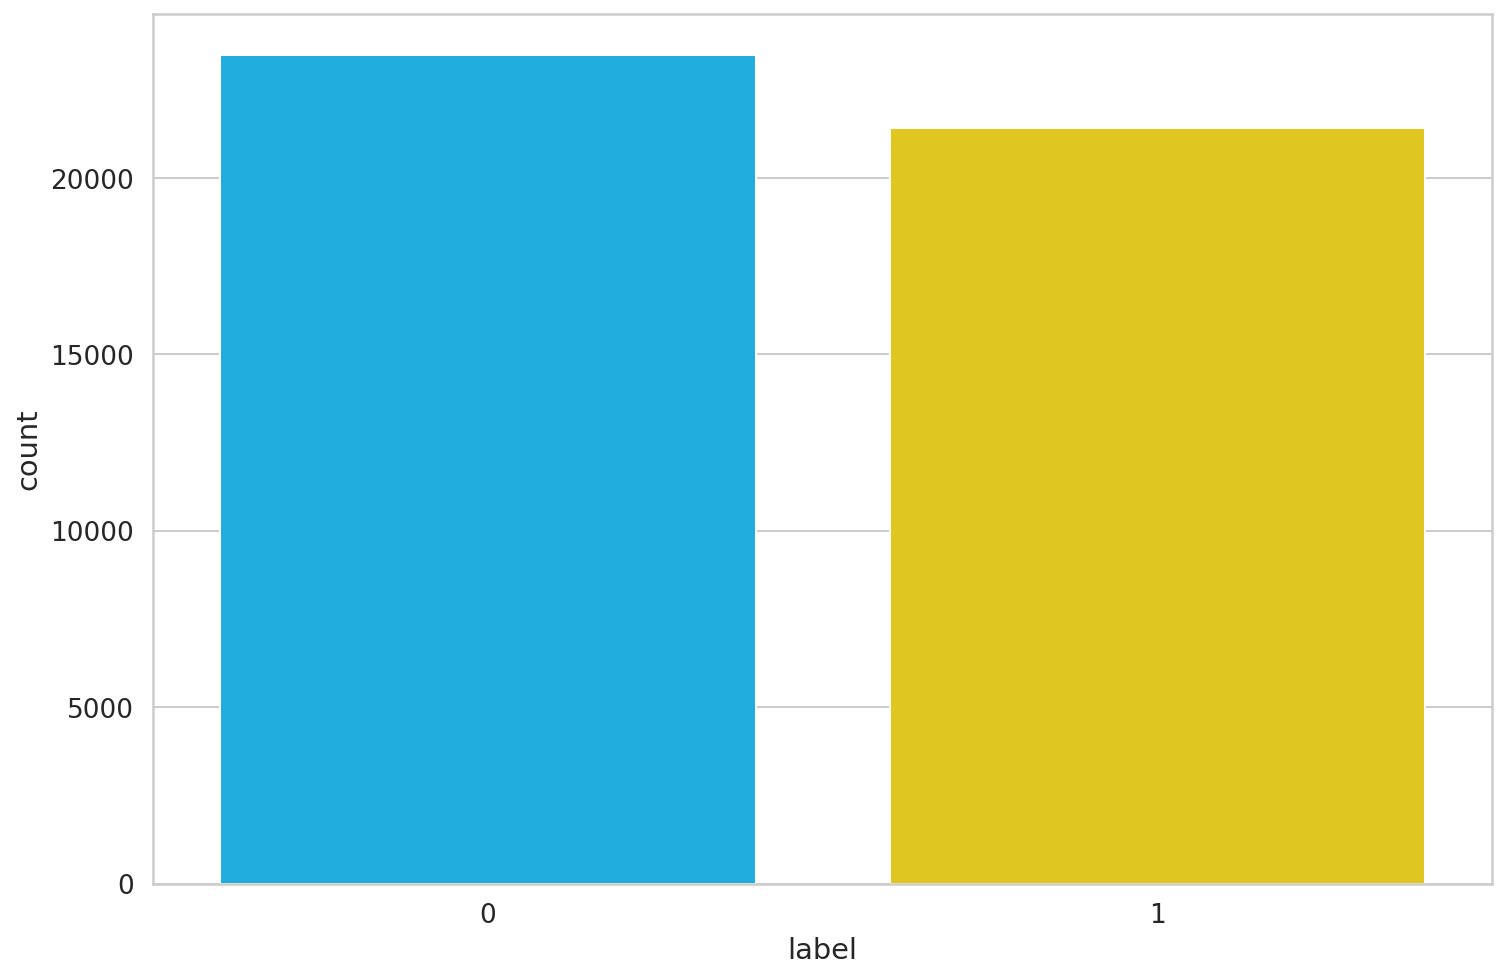

In [73]:
sns.countplot(combined.label)

In [22]:
class_names = ['false', 'true']

In [23]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [36]:
from tqdm import tqdm

In [41]:
!pip install pandarallel

  Created wheel for pandarallel: filename=pandarallel-1.4.8-py3-none-any.whl size=16111 sha256=72a3a9abc7ccf3549b86b81ba3d38458fbb4270b7debe15f10c541f41f773a34
  Stored in directory: /root/.cache/pip/wheels/c7/f2/4e/e40c8b9344cccf6b8a02d8d8808ba837e72b607c4be946878a
Successfully built pandarallel
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [42]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


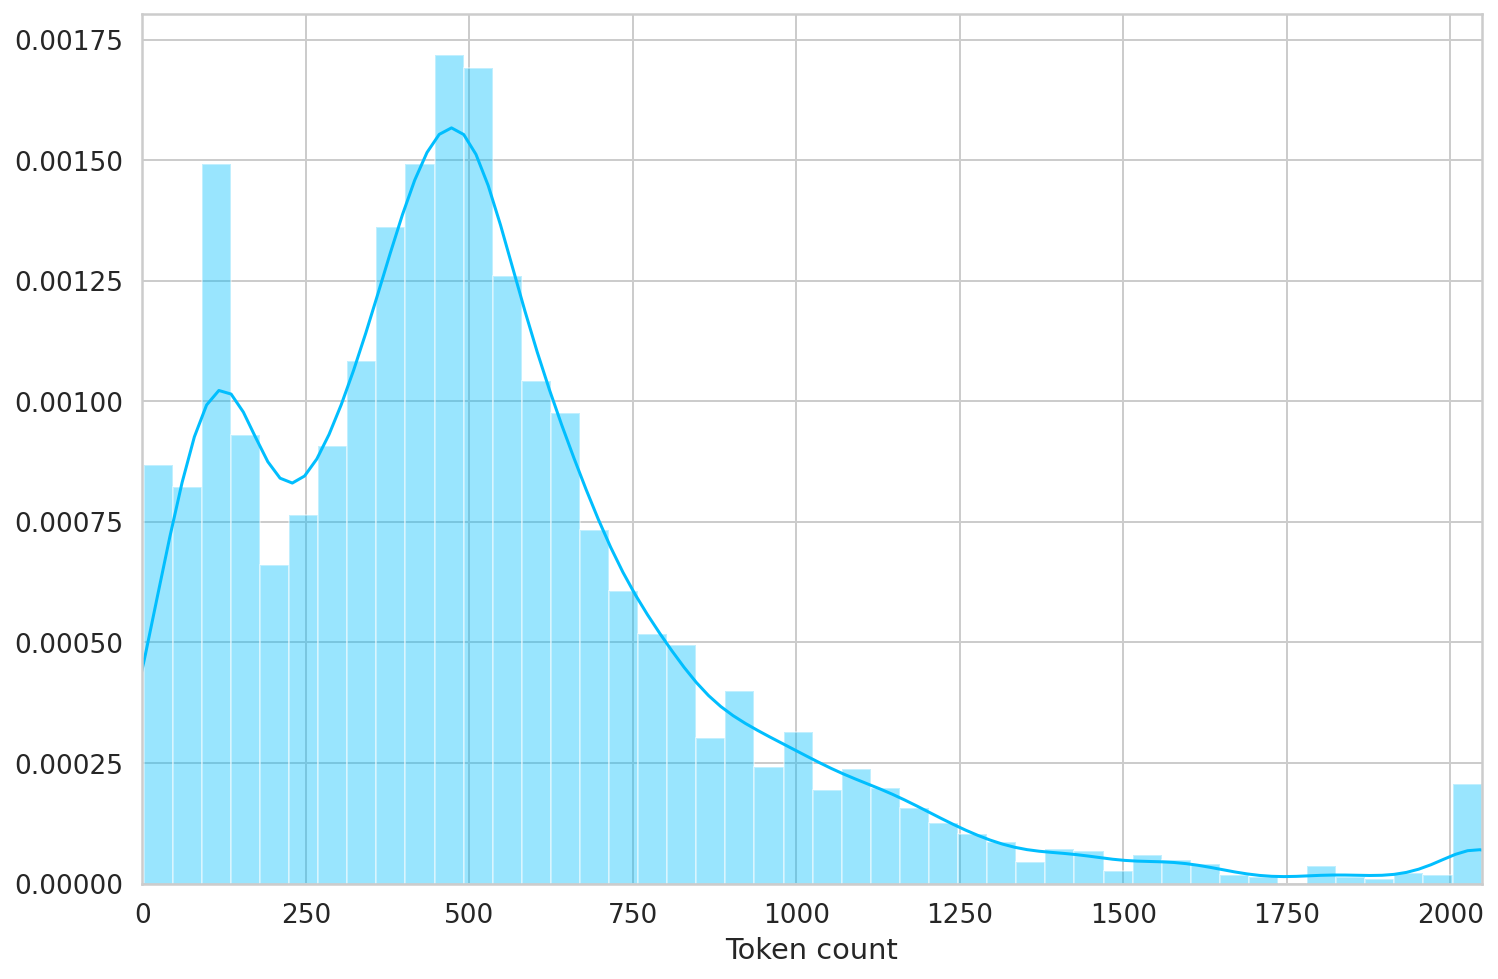

In [75]:
#token_lens = []

'''for txt in tqdm(combined.text.sample(5000)):
    tokens = tokenizer.encode(txt, max_length=2048)
    token_lens.append(len(tokens))
'''    

token_lens = combined.text.sample(5000).parallel_apply(lambda s: len(tokenizer.encode(s, max_length=2048)))

sns.distplot(token_lens)
plt.xlim([0, 2048]);
plt.xlabel('Token count');

In [97]:
#BERT can't handle above a certain number of tokens
#It's just THAT complicated.
#One solution - predict on article TITLE, rather than text.
MAX_LEN = 128 #1750

In [98]:
sample_txt = combined.text.sample(1).values[0]
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: #disruptj20 protesters on the move, many leaving the checkpoint. And they've chained themselves together pic.twitter.com/jYvaY75hND  Ryan Lovelace (@LovelaceRyanD) January 20, 2017
   Tokens: ['#', 'disrupt', '##j', '##20', 'protesters', 'on', 'the', 'move', ',', 'many', 'leaving', 'the', 'check', '##point', '.', 'And', 'they', "'", 've', 'chained', 'themselves', 'together', 'p', '##ic', '.', 't', '##wi', '##tter', '.', 'com', '/', 'j', '##Y', '##va', '##Y', '##75', '##h', '##ND', 'Ryan', 'Love', '##lace', '(', '@', 'Love', '##lace', '##R', '##yan', '##D', ')', 'January', '20', ',', '2017']
Token IDs: [108, 26499, 3361, 10973, 14339, 1113, 1103, 1815, 117, 1242, 2128, 1103, 4031, 7587, 119, 1262, 1152, 112, 1396, 25953, 2310, 1487, 185, 1596, 119, 189, 10073, 8634, 119, 3254, 120, 179, 3663, 2497, 3663, 26253, 1324, 16769, 3730, 2185, 17510, 113, 137, 2185, 17510, 2069, 6582, 2137, 114, 1356, 1406, 117, 1504]


In [99]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=MAX_LEN,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [100]:
encoding['input_ids']

tensor([[  101,   108, 26499,  3361, 10973, 14339,  1113,  1103,  1815,   117,
          1242,  2128,  1103,  4031,  7587,   119,  1262,  1152,   112,  1396,
         25953,  2310,  1487,   185,  1596,   119,   189, 10073,  8634,   119,
          3254,   120,   179,  3663,  2497,  3663, 26253,  1324, 16769,  3730,
          2185, 17510,   113,   137,  2185, 17510,  2069,  6582,  2137,   114,
          1356,  1406,   117,  1504,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

In [101]:
class FakeNewsDataset(Dataset):

    def __init__(self, news, targets, tokenizer, max_len):
        self.news = news
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.news)

    def __getitem__(self, item):
        newsitem = str(self.news[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
          newsitem,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'newsitem_text': newsitem,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [102]:
df_train, df_test = train_test_split(combined, test_size=0.1)
df_val, df_test = train_test_split(df_test, test_size=0.5)
df_train.shape, df_val.shape, df_test.shape

((40408, 5), (2245, 5), (2245, 5))

In [103]:
df_train.label

14162    1
3201     1
17382    1
18162    0
15538    0
        ..
20037    0
13039    1
15010    1
2039     1
19195    0
Name: label, Length: 40408, dtype: int64

In [104]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = FakeNewsDataset(news=df.text.to_numpy(),
                         targets=df.label.to_numpy(),
                         tokenizer=tokenizer,
                         max_len=max_len)

    return DataLoader(ds,
                      batch_size=batch_size,
                      num_workers=2)

In [105]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [106]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['newsitem_text', 'input_ids', 'attention_mask', 'targets'])

In [107]:
data

{'newsitem_text': ['OSLO (Reuters) - Ex-Bosnian Serb general Rakto Mladic s conviction for war crimes did not come as a surprise, Serbia s prime minister said on Wednesday.  We need to look to the future, so we finally have a stable country,  Ana Brnabic told reporters during a visit to Oslo.  We need to leave the past behind,  she said. A U.N. tribunal convicted Mladic of genocide and crimes against humanity for orchestrating massacres and ethnic cleansing during Bosnia s war and sentenced him to life in prison. ',
  'WASHINGTON (Reuters) - The gunshots that ripped through a congressional Republican team practice early Wednesday on a Virginia baseball field not only shook the U.S. Capitol but also upended what many Americans consider a symbol of fair play and summer fun. Before he was killed, a gunman shot and wounded a senior Republican House leader and several others getting ready on an Alexandria, Virginia, field for a charity game between Republicans and Democrats on Thursday in n

In [108]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


In [109]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [110]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [111]:
last_hidden_state

tensor([[[ 0.2311,  0.2904, -0.0267,  ..., -0.3222,  0.2988,  0.2969],
         [ 0.3889, -0.2840,  0.4332,  ..., -0.1321,  0.3718,  0.3070],
         [-0.0385, -0.2142, -0.0417,  ...,  0.0690, -0.0016,  0.4056],
         ...,
         [-0.0483,  0.7575,  0.2553,  ...,  0.0726,  0.5840,  0.1450],
         [-0.0878,  0.1976,  0.3319,  ..., -0.0972,  0.2386,  0.7192],
         [-0.1894,  0.2315,  0.1637,  ..., -0.2682,  0.3937,  0.4667]]],
       grad_fn=<NativeLayerNormBackward>)

In [112]:
bert_model.config.hidden_size

768

In [113]:
pooled_output.shape

torch.Size([1, 768])

In [115]:
class FakeNewsClassifier(nn.Module):

    def __init__(self, n_classes):
        super(FakeNewsClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [116]:
model = FakeNewsClassifier(len(class_names))
model = model.to(device)

In [119]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

F.softmax(model(input_ids, attention_mask), dim=1)

torch.Size([16, 128])
torch.Size([16, 128])


tensor([[0.6502, 0.3498],
        [0.7806, 0.2194],
        [0.6651, 0.3349],
        [0.3931, 0.6069],
        [0.5385, 0.4615],
        [0.6587, 0.3413],
        [0.7921, 0.2079],
        [0.7086, 0.2914],
        [0.6436, 0.3564],
        [0.6385, 0.3615],
        [0.5617, 0.4383],
        [0.7983, 0.2017],
        [0.5426, 0.4574],
        [0.7257, 0.2743],
        [0.7619, 0.2381],
        [0.4899, 0.5101]], device='cuda:0', grad_fn=<SoftmaxBackward>)

## TRAINING

In [120]:
'''
BERT PAPER RECOMMENDS:
Batch size: 16, 32
Learning rate (Adam): 5e-5, 3e-5, 2e-5
Number of epochs: 2, 3, 4
'''

EPOCHS = 10

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [124]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [122]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

        return correct_predictions.double() / n_examples, np.mean(losses)

In [123]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
        scheduler, 
        len(df_train)
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn, 
        device, 
        len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------


/opt/conda/conda-bld/pytorch_1587428398394/work/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


KeyboardInterrupt: 